# Bài tập cuối kỳ môn Machine Learning: Dự đoán xem một nhân viên sẽ nghỉ việc hay không

## Thư viện

In [279]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Define các hàm để in ra sự so sánh (nếu có)

In [280]:
def visualize_metrics(metrics):

    # List of classifiers and metrics
    classifiers = list(metrics.keys())
    metric_names = list(metrics[classifiers[0]].keys())


    bar_width = 0.15  # Set the width of the bars
    padding = 0.05  # Adjust the padding value as desired

    # Set the positions of the x-axis ticks
    x_pos = np.arange(len(classifiers))

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the bar chart size

    # Plot each metric as a group of bars
    for i, metric in enumerate(metric_names):
        metric_values = [metrics[classifier][metric] for classifier in classifiers]
        bar_positions = x_pos + ((bar_width + padding) * i)
        ax.bar(bar_positions, metric_values, bar_width, label=metric)

    # Set the labels and title
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x_pos + (((bar_width + padding) * (len(metric_names) - 1)) / 2))
    ax.set_xticklabels(classifiers)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.tight_layout()
    plt.show()




def print_metrics(accuracy, precision, recall, f1):
        print("Accuracy: {:.4f}".format(accuracy))
        print("Precision: {:.4f}".format(precision))
        print("Recall: {:.4f}".format(recall))
        print("F1-Score: {:.4f}".format(f1))

def plot_loss_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_accuracy_history_comparision(history_before, history_after):
    plt.figure(figsize=(12, 5))

    # Plot for history_before
    plt.subplot(1, 2, 1)
    plt.plot(history_before.history['accuracy'], label='Training Accuracy (Before)')
    plt.plot(history_before.history['val_accuracy'], label='Validation Accuracy (Before)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History Before')

    # Plot for history_after
    plt.subplot(1, 2, 2)
    plt.plot(history_after.history['accuracy'], label='Training Accuracy (After)')
    plt.plot(history_after.history['val_accuracy'], label='Validation Accuracy (After)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History After')

    # Adjust layout
    plt.tight_layout()

    plt.show()
    
def plot_loss_history_comparision(history_before, history_after):
    plt.figure(figsize=(12, 5))

    # Plot for history_before
    plt.subplot(1, 2, 1)
    plt.plot(history_before.history['loss'], label='Training Loss (Before)')
    plt.plot(history_before.history['val_loss'], label='Validation Loss (Before)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History Before')

    # Plot for history_after
    plt.subplot(1, 2, 2)
    plt.plot(history_after.history['loss'], label='Training Loss (After)')
    plt.plot(history_after.history['val_loss'], label='Validation Loss (After)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History After')

    # Adjust layout
    plt.tight_layout()

    plt.show()



## Phần 1 + Phần 4: Data Exploration + Data Preprocessing + Using Feature Selection for Reducing Overfitting

### Data cleaning

In [281]:
df = pd.DataFrame(pd.read_csv('Employee.csv'))
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [282]:
df.isna().sum()

# Không có giá trị null trong tập dữ liệu nên không cần xử lý "Missing Values"

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [283]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Xử lý dữ liệu trùng lặp.

### Data handling Categorical và Transformation


In [284]:
df['Education'].unique()


array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [285]:
df['City'].unique()

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [286]:
df['PaymentTier'].unique()

array([3, 1, 2], dtype=int64)

In [287]:
# Có 3 features thuộc dạng categorical nên cần phải chuyển đổi

df_dummies = pd.get_dummies(df, columns=['JoiningYear', 'Education', 'City', 'PaymentTier', 'EverBenched', 'Gender'])
df_dummies

,Age,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,...,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,EverBenched_No,EverBenched_Yes,Gender_Female,Gender_Male
0,34,0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,True,True,False,False,True
1,28,3,1,False,True,False,False,False,False,False,...,False,False,True,True,False,False,True,False,True,False
2,38,2,0,False,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,True,False
3,27,5,1,False,False,False,False,True,False,False,...,True,False,False,False,False,True,True,False,False,True
4,24,2,1,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,2,0,False,False,False,False,False,True,False,...,False,False,True,False,True,False,True,False,True,False
4647,30,2,0,False,False,False,False,True,False,False,...,False,False,True,False,False,True,True,False,False,True
4649,37,2,1,False,True,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True
4650,27,5,1,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,True


In [288]:
df_dummies.dtypes

Age                          int64
ExperienceInCurrentDomain    int64
LeaveOrNot                   int64
JoiningYear_2012              bool
JoiningYear_2013              bool
JoiningYear_2014              bool
JoiningYear_2015              bool
JoiningYear_2016              bool
JoiningYear_2017              bool
JoiningYear_2018              bool
Education_Bachelors           bool
Education_Masters             bool
Education_PHD                 bool
City_Bangalore                bool
City_New Delhi                bool
City_Pune                     bool
PaymentTier_1                 bool
PaymentTier_2                 bool
PaymentTier_3                 bool
EverBenched_No                bool
EverBenched_Yes               bool
Gender_Female                 bool
Gender_Male                   bool
dtype: object

In [289]:
le = LabelEncoder()

name = list(df_dummies.columns)
type = df_dummies.dtypes

for i in range(len(type)):
    if type[i] == 'object':
        le.fit_transform(df_dummies[name[i]])
        df_dummies[name[i]] = le.transform(df_dummies[name[i]])

df_dummies

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\3446361408.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object':


,Age,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,...,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3,EverBenched_No,EverBenched_Yes,Gender_Female,Gender_Male
0,34,0,0,False,False,False,False,False,True,False,...,True,False,False,False,False,True,True,False,False,True
1,28,3,1,False,True,False,False,False,False,False,...,False,False,True,True,False,False,True,False,True,False
2,38,2,0,False,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,True,False
3,27,5,1,False,False,False,False,True,False,False,...,True,False,False,False,False,True,True,False,False,True
4,24,2,1,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,2,0,False,False,False,False,False,True,False,...,False,False,True,False,True,False,True,False,True,False
4647,30,2,0,False,False,False,False,True,False,False,...,False,False,True,False,False,True,True,False,False,True
4649,37,2,1,False,True,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,True
4650,27,5,1,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,True


### Data Exploration

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'ExperienceInCurrentDomain'}>],
       [<Axes: title={'center': 'LeaveOrNot'}>, <Axes: >]], dtype=object)

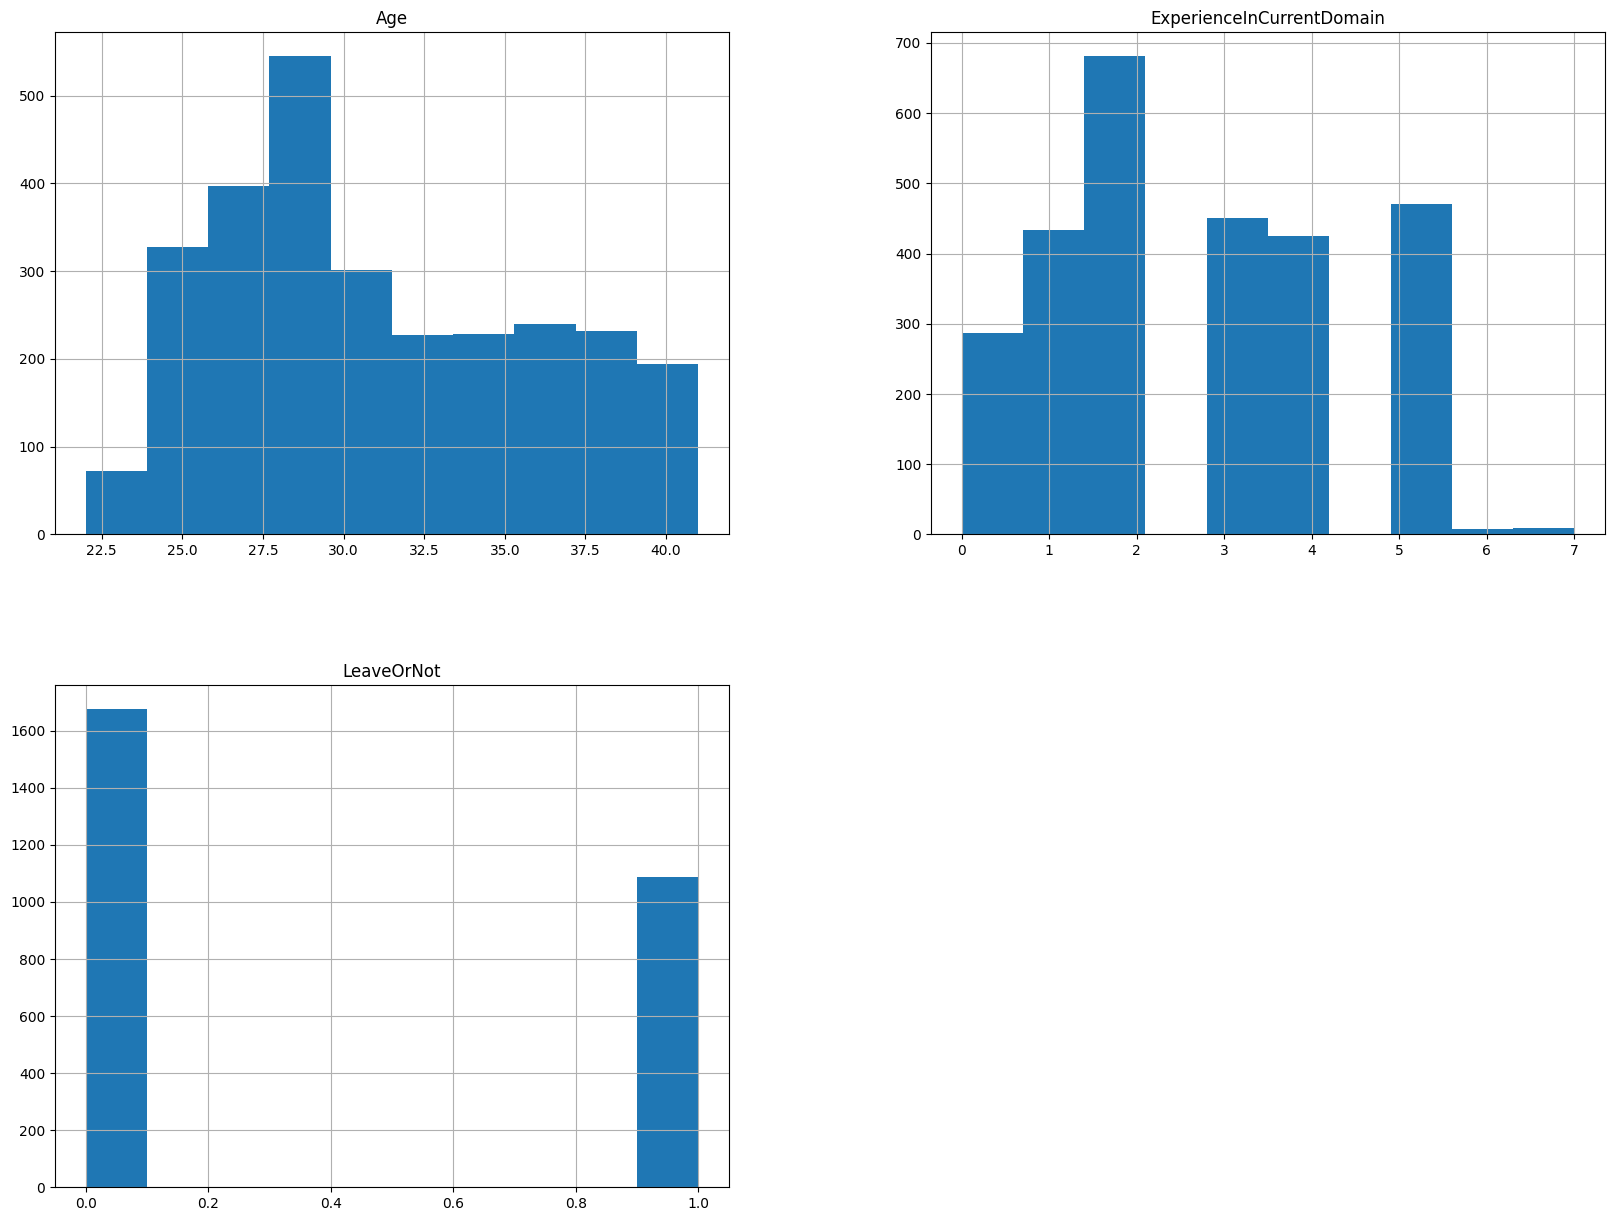

In [290]:
df_dummies.hist(figsize=(20, 15))

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

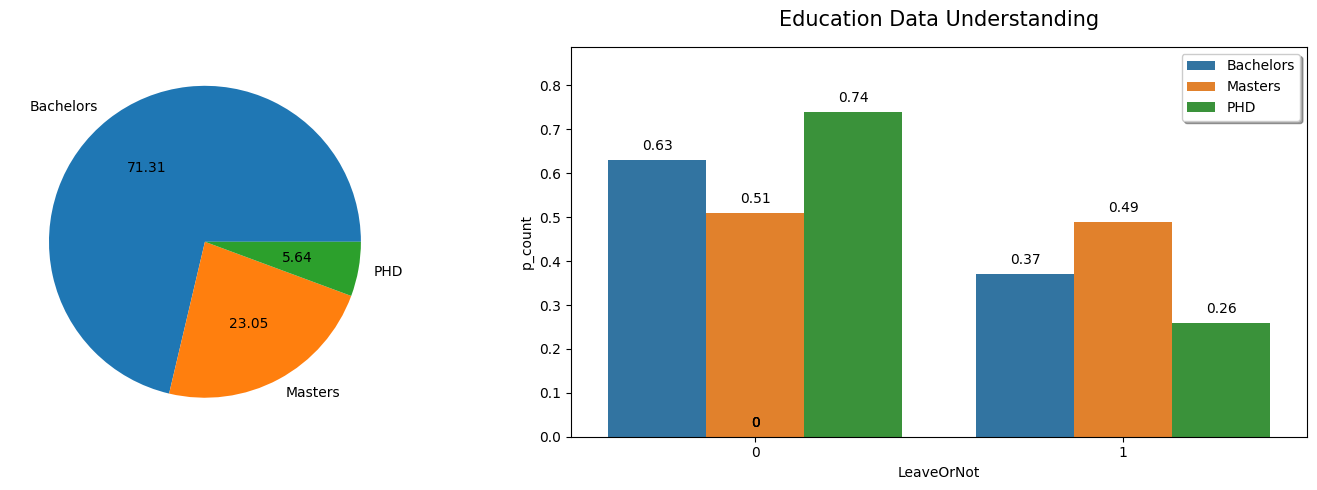

In [291]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên trình độ học vấn

data1=df.Education.value_counts().reset_index()
data2=df.groupby(['Education','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Education.unique():
    msg=data2[data2.Education==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Education'], autopct='%.2f')
ax[1].set_title('Education Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Education', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

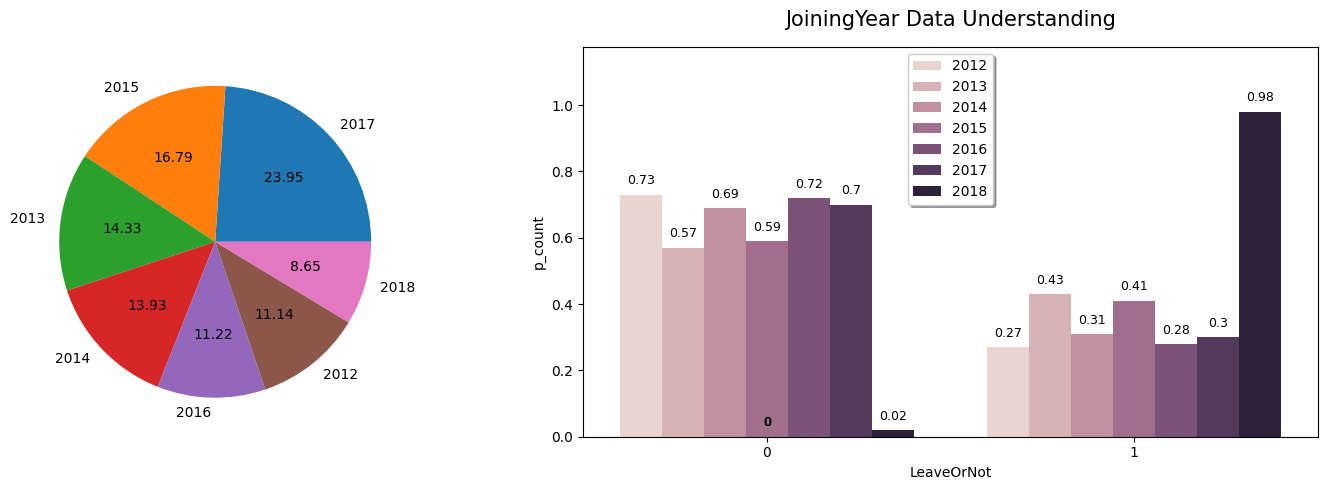

In [292]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên năm ứng tuyển

data1=df.JoiningYear.value_counts().reset_index()
data2=df.groupby(['JoiningYear','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.JoiningYear.unique():
    msg=data2[data2.JoiningYear==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['JoiningYear'], autopct='%.2f')
ax[1].set_title('JoiningYear Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='JoiningYear', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

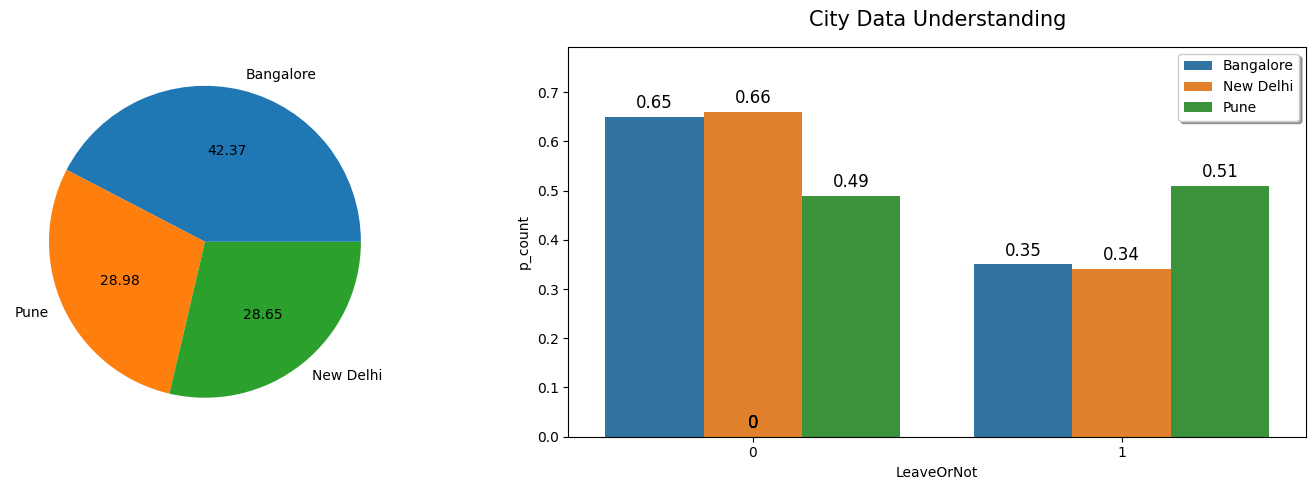

In [293]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên thành phố sinh sống

data1=df.City.value_counts().reset_index()
data2=df.groupby(['City','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.City.unique():
    msg=data2[data2.City==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['City'], autopct='%.2f')
ax[1].set_title('City Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='City', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


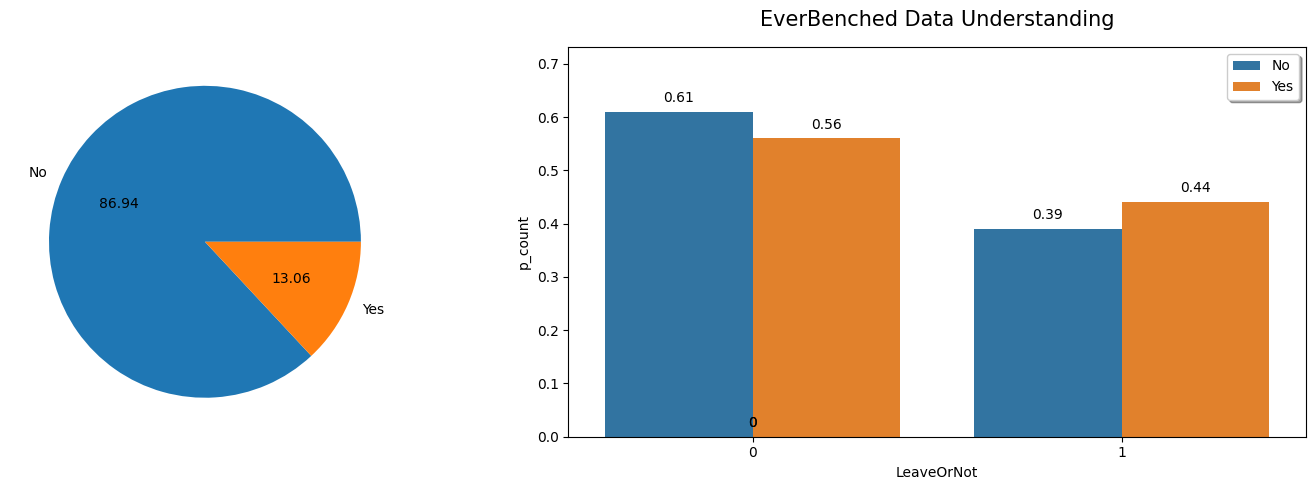

In [294]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên lịch sử thăng cấp

data1=df.EverBenched.value_counts().reset_index()
data2=df.groupby(['EverBenched','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.EverBenched.unique():
    msg=data2[data2.EverBenched==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['EverBenched'], autopct='%.2f')
ax[1].set_title('EverBenched Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='EverBenched', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_6964\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


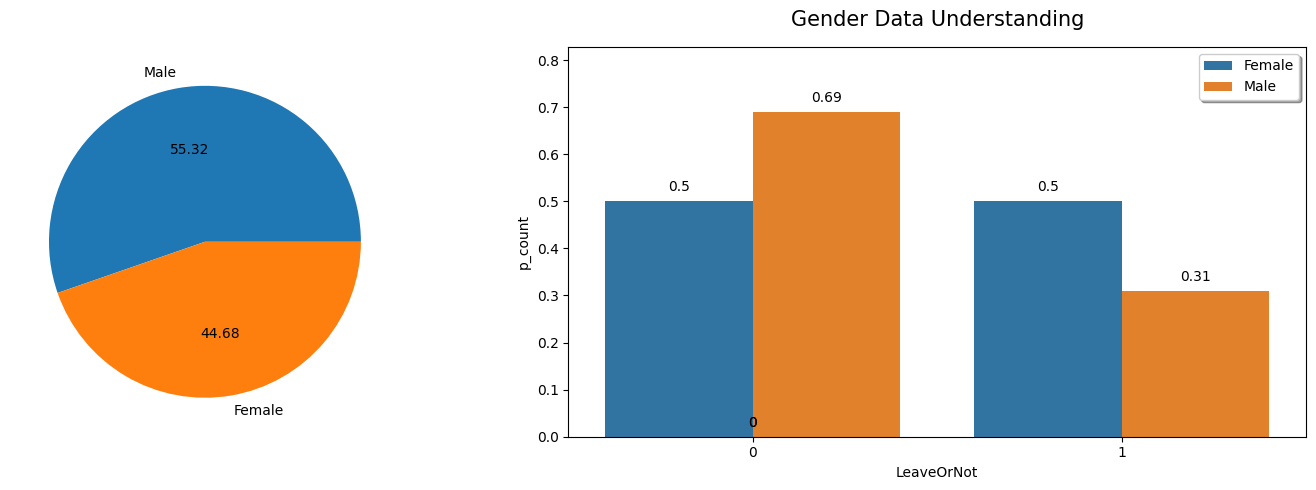

In [295]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên giới tính

data1=df.Gender.value_counts().reset_index()
data2=df.groupby(['Gender','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Gender.unique():
    msg=data2[data2.Gender==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Gender'], autopct='%.2f')
ax[1].set_title('Gender Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Gender', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

### Sử dụng Pearson Corelation để xem điểm tương quang giữa các Feature

<Axes: >

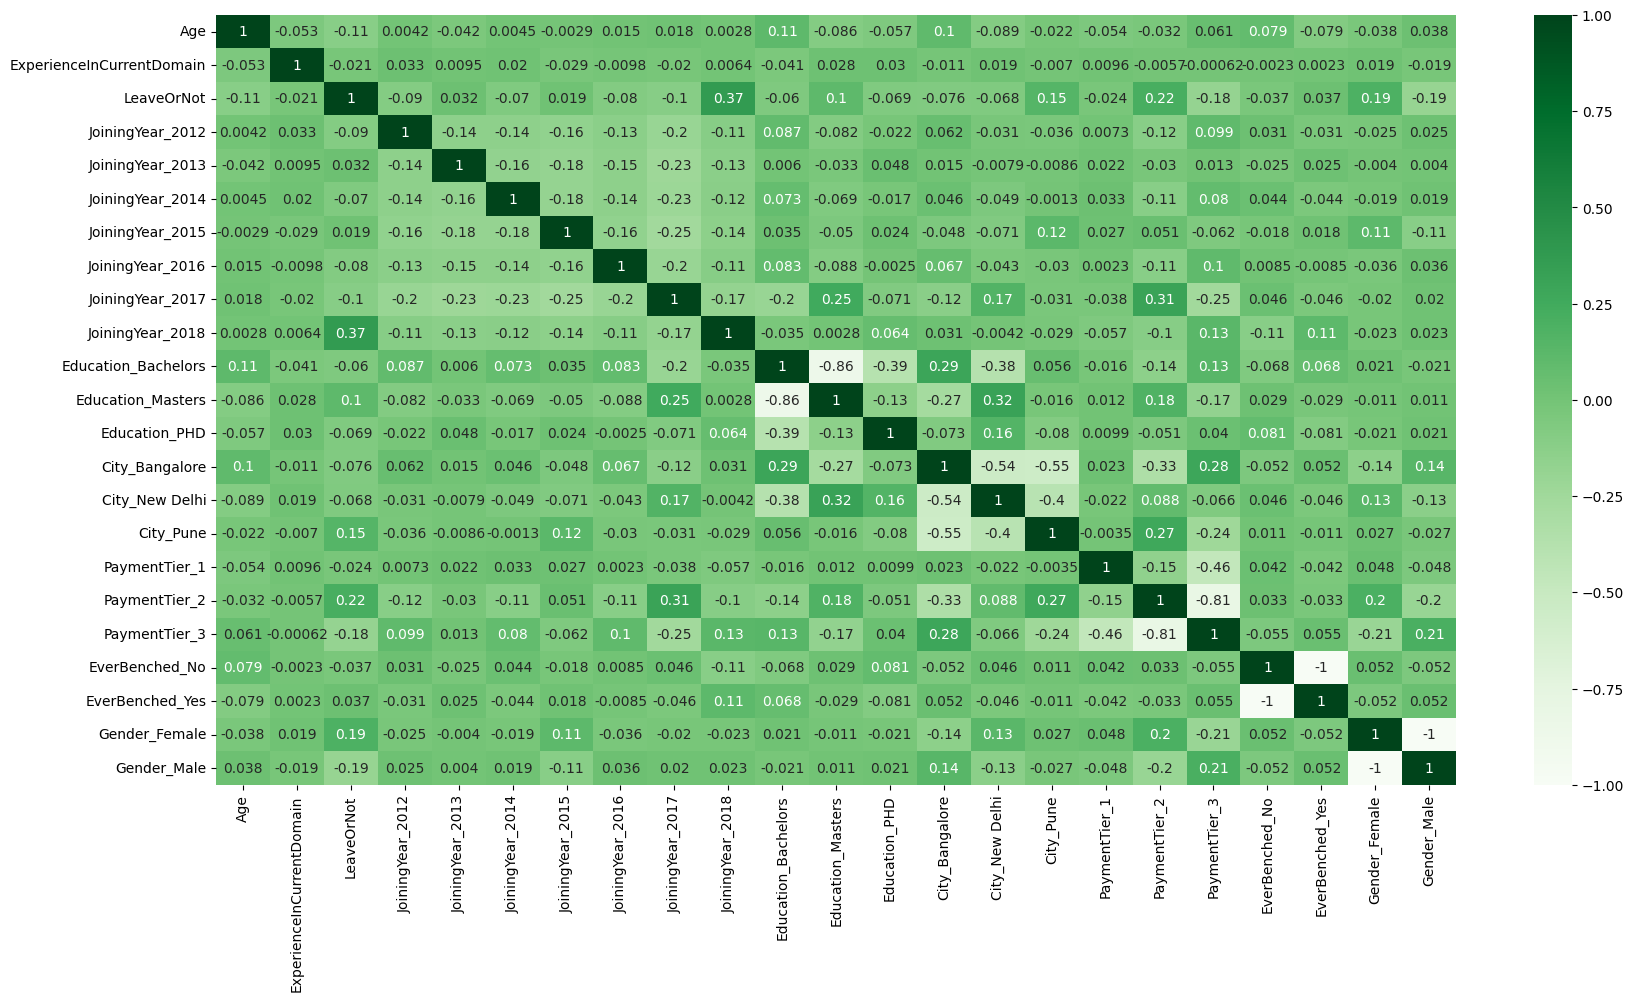

In [296]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap="Greens")

In [297]:
# # từ bản tương quan có thể thấy rằng bằng thạc sĩ hoặc cử nhân có tương quang tương đương nhau nên có thểm drop 1 trong 2
corr_matrix = df_dummies.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
to_drop.remove("LeaveOrNot") if "LeaveOrNot" in to_drop else None
df_dummies.drop(to_drop, axis=1, inplace=True)

<Axes: >

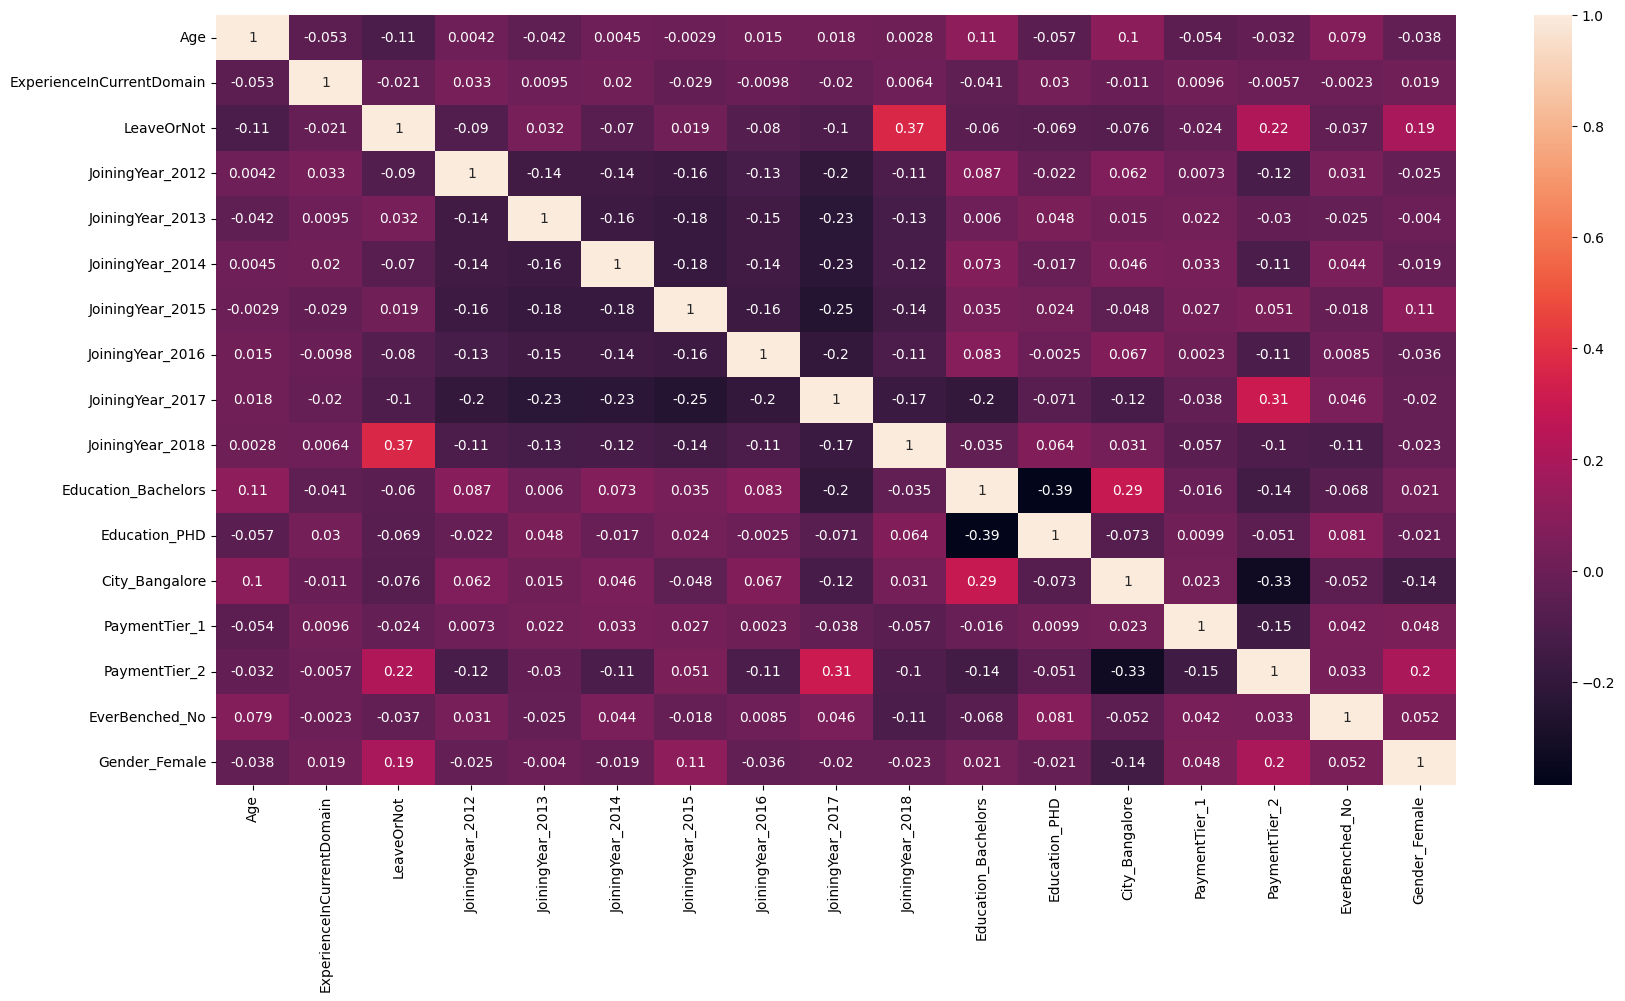

In [298]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True)

#### Regularization

In [299]:
X = df_dummies.drop('LeaveOrNot', axis=1)
y = df_dummies['LeaveOrNot']

In [300]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

In [301]:
X_scaled


array([[ 0.59652788, -1.64213199, -0.35412874, ..., -0.50970526,
         0.38759371, -0.89873103],
       [-0.57811215,  0.22085316, -0.35412874, ..., -0.50970526,
         0.38759371,  1.11267995],
       [ 1.37962124, -0.40014189, -0.35412874, ..., -0.50970526,
         0.38759371,  1.11267995],
       ...,
       [ 1.1838479 , -0.40014189, -0.35412874, ...,  1.96191814,
         0.38759371, -0.89873103],
       [-0.77388549,  1.46284326, -0.35412874, ..., -0.50970526,
         0.38759371, -0.89873103],
       [-0.18656548, -0.40014189,  2.82383179, ..., -0.50970526,
        -2.58002126, -0.89873103]])

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=5, test_size=0.3)

## Phần 2: Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing

### Các mô hình học máy cơ bản

#### KNN

#### Linear Regression

#### Decision Tree

#### Naive Bayes

#### SVM

#### Logistic Regression

### Ứng dụng các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

In [303]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

gb_accuracy = accuracy_score(y_test, y_test_pred)
gb_precision = precision_score(y_test, y_test_pred)
gb_recall = recall_score(y_test, y_test_pred)
gb_f1 = f1_score(y_test, y_test_pred)

print_metrics(gb_accuracy, gb_precision, gb_recall, gb_f1)

gb_train_before = accuracy_score(y_train, y_train_pred)
gb_test_before = gb_accuracy




Accuracy: 0.7578
Precision: 0.7696
Recall: 0.5446
F1-Score: 0.6378


#### AdaBoost

In [304]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_accuracy = accuracy_score(y_test, y_test_pred)
ada_precision = precision_score(y_test, y_test_pred)
ada_recall = recall_score(y_test, y_test_pred)
ada_f1 = f1_score(y_test, y_test_pred)

print_metrics(ada_accuracy, ada_precision, ada_recall, ada_f1)

ada_train_before = accuracy_score(y_train, y_train_pred)
ada_test_before = ada_accuracy



Accuracy: 0.7157
Precision: 0.6831
Recall: 0.5108
F1-Score: 0.5845


#### Bagging

In [305]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier()

bagging_clf.fit(X_train, y_train)

y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_test_pred)
bagging_precision = precision_score(y_test, y_test_pred)
bagging_recall = recall_score(y_test, y_test_pred)
bagging_f1 = f1_score(y_test, y_test_pred)

print_metrics(bagging_accuracy, bagging_precision, bagging_recall, bagging_f1)

bagging_train_before = accuracy_score(y_train, y_train_pred)
bagging_test_before = bagging_accuracy





Accuracy: 0.7048
Precision: 0.6361
Recall: 0.5754
F1-Score: 0.6042


#### Random Forest

In [306]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_test_pred)
rf_precision = precision_score(y_test, y_test_pred)
rf_recall = recall_score(y_test, y_test_pred)
rf_f1 = f1_score(y_test, y_test_pred)

print_metrics(rf_accuracy, rf_precision, rf_recall, rf_f1)

rf_train_before = accuracy_score(y_train, y_train_pred)
rf_test_before = rf_accuracy



Accuracy: 0.7084
Precision: 0.6416
Recall: 0.5785
F1-Score: 0.6084


#### Voting Classifier

In [307]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Create individual classifiers
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)]
)

voting_clf.fit(X_train, y_train)
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

voting_accuracy = accuracy_score(y_test, y_test_pred)
voting_precision = precision_score(y_test, y_test_pred)
voting_recall = recall_score(y_test, y_test_pred)
voting_f1 = f1_score(y_test, y_test_pred)

print_metrics(voting_accuracy, voting_precision, voting_recall, voting_f1)

voting_train_before = accuracy_score(y_train, y_train_pred)
voting_test_before = voting_accuracy


Accuracy: 0.7506
Precision: 0.7418
Recall: 0.5569
F1-Score: 0.6362


#### Stacking

In [308]:
from sklearn.ensemble import StackingClassifier


stacking_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    final_estimator=lr_clf
)
stacking_clf.fit(X_train, y_train)
y_train_pred = stacking_clf.predict(X_train)
y_test_pred = stacking_clf.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_test_pred)
stacking_precision = precision_score(y_test, y_test_pred)
stacking_recall = recall_score(y_test, y_test_pred)
stacking_f1 = f1_score(y_test, y_test_pred)

print_metrics(stacking_accuracy, stacking_precision, stacking_recall, stacking_f1)

stacking_train_before = accuracy_score(y_train, y_train_pred)
stacking_test_before = stacking_accuracy



Accuracy: 0.7602
Precision: 0.7625
Recall: 0.5631
F1-Score: 0.6478


#### Hàm visualize_metrics sử dụng để so sánh hiệu suất của nhiều bộ phân loại (classifiers) khác nhau dựa trên các độ đo đánh giá như accuracy (độ chính xác), precision (độ chính xác dương tính), recall (độ phục hồi), và F1-score.

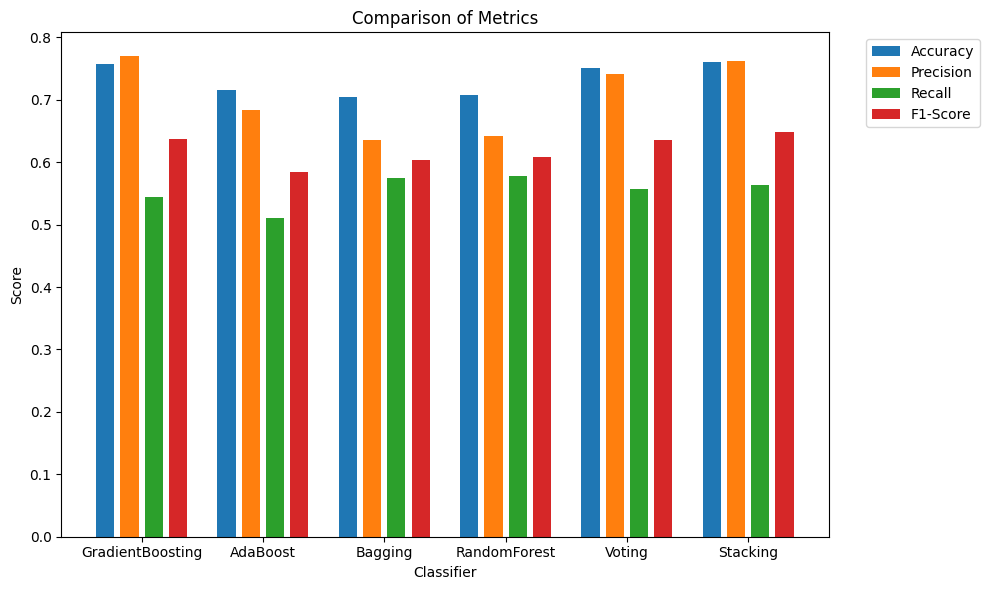

In [309]:

metrics = {
    'GradientBoosting': {
        'Accuracy': gb_accuracy,
        'Precision': gb_precision,
        'Recall': gb_recall,
        'F1-Score': gb_f1
    },

    'AdaBoost': {
        'Accuracy': ada_accuracy,
        'Precision': ada_precision,
        'Recall': ada_recall,
        'F1-Score': ada_f1
    },

    'Bagging': {
        'Accuracy': bagging_accuracy,
        'Precision': bagging_precision,
        'Recall': bagging_recall,
        'F1-Score': bagging_f1
    },

    'RandomForest': {
        'Accuracy': rf_accuracy,
        'Precision': rf_precision,
        'Recall': rf_recall,
        'F1-Score': rf_f1
    },

    'Voting': {
        'Accuracy': voting_accuracy,
        'Precision': voting_precision,
        'Recall': voting_recall,
        'F1-Score': voting_f1
    },

    'Stacking': {
        'Accuracy': stacking_accuracy,
        'Precision': stacking_precision,
        'Recall': stacking_recall,
        'F1-Score': stacking_f1
    }
}

visualize_metrics(metrics=metrics)


## Phần 3: Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán

### Feed Forward Neurl Network


Epoch 1/100
61/61 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.6169 - val_loss: 0.6596 - val_accuracy: 0.6675
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6939 - val_loss: 0.6365 - val_accuracy: 0.6867
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6245 - accuracy: 0.7218 - val_loss: 0.6181 - val_accuracy: 0.7084
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.7311 - val_loss: 0.6028 - val_accuracy: 0.7217
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7347 - val_loss: 0.5909 - val_accuracy: 0.7265
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5812 - accuracy: 0.7456 - val_loss: 0.5810 - val_accuracy: 0.7253
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.7482 - val_loss: 0.5725 - val_accuracy: 0.7277
Epoch 8/100
6

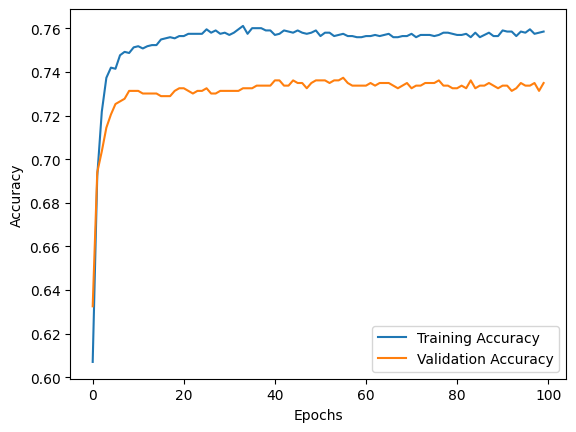

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_187 (Dense)           (None, 1)                 17        
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [310]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid'),
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy', optimizer='adam')

history_FFNW_before = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

plot_accuracy_history(history_FFNW)

print(model_FFNW.summary())

### Reccurent Neural Network

Epoch 1/100
61/61 [==============================] - 1s 8ms/step - loss: 0.9938 - accuracy: 0.5042 - val_loss: 0.9827 - val_accuracy: 0.5020
Epoch 2/100
61/61 [==============================] - 0s 4ms/step - loss: 0.9658 - accuracy: 0.5072 - val_loss: 0.9557 - val_accuracy: 0.5023
Epoch 3/100
61/61 [==============================] - 0s 4ms/step - loss: 0.9400 - accuracy: 0.5090 - val_loss: 0.9305 - val_accuracy: 0.5056
Epoch 4/100
61/61 [==============================] - 0s 4ms/step - loss: 0.9165 - accuracy: 0.5128 - val_loss: 0.9071 - val_accuracy: 0.5096
Epoch 5/100
61/61 [==============================] - 0s 4ms/step - loss: 0.8948 - accuracy: 0.5218 - val_loss: 0.8863 - val_accuracy: 0.5323
Epoch 6/100
61/61 [==============================] - 0s 4ms/step - loss: 0.8746 - accuracy: 0.5414 - val_loss: 0.8667 - val_accuracy: 0.5447
Epoch 7/100
61/61 [==============================] - 0s 4ms/step - loss: 0.8558 - accuracy: 0.5471 - val_loss: 0.8483 - val_accuracy: 0.5447
Epoch 8/100
6

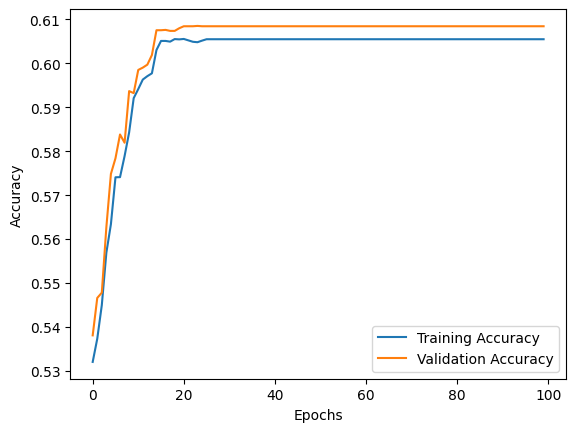

In [311]:
model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid', return_sequences=True, input_shape= (X_train.shape[1],1))
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN_before = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plot_accuracy_history(history_RNN)


## Phần 4: Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán

### Các mô hình học máy cơ bản

### Ứng dụng các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

In [312]:
gb_clf = GradientBoostingClassifier(max_depth=5, n_estimators=200, learning_rate=0.05)

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

gb_train_after = accuracy_score(y_train, y_train_pred)
gb_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(gb_train_before))
print("Test: {:.4f}".format(gb_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(gb_train_after))
print("Test: {:.4f}".format(gb_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.8030
Test: 0.7578

Accuracy sau khi áp dụng overfitting:
Train: 0.8418
Test: 0.7602


#### AdaBoost

In [313]:
base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_split=5)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=0.5)

ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_train_after = accuracy_score(y_train, y_train_pred)
ada_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(ada_train_before))
print("Test: {:.4f}".format(ada_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(ada_train_after))
print("Test: {:.4f}".format(ada_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.7616
Test: 0.7157

Accuracy sau khi áp dụng overfitting:
Train: 0.8263
Test: 0.7542


c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


#### Bagging

In [314]:
base_estimator = RandomForestClassifier(n_estimators=100)
bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=10)

bagging_clf.fit(X_train, y_train)
y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

bagging_train_after = accuracy_score(y_train, y_train_pred)
bagging_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(bagging_train_before))
print("Test: {:.4f}".format(bagging_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(bagging_train_after))
print("Test: {:.4f}".format(bagging_test_after))

c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy trước khi áp dụng overfitting:
Train: 0.9090
Test: 0.7048

Accuracy sau khi áp dụng overfitting:
Train: 0.8987
Test: 0.7169


#### Random Forest

In [315]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

rf_train_after = accuracy_score(y_train, y_train_pred)
rf_test_after = accuracy_score(y_test, y_test_pred)


print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(rf_train_before))
print("Test: {:.4f}".format(rf_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(rf_train_after))
print("Test: {:.4f}".format(rf_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.9230
Test: 0.7084

Accuracy sau khi áp dụng overfitting:
Train: 0.7746
Test: 0.7590


#### Voting Classifier

In [316]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1)
lr_clf = LogisticRegression(C=0.1)

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

voting_train_after = accuracy_score(y_train, y_train_pred)
voting_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(voting_train_before))
print("Test: {:.4f}".format(voting_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(voting_train_after))
print("Test: {:.4f}".format(voting_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.8232
Test: 0.7506

Accuracy sau khi áp dụng overfitting:
Train: 0.7808
Test: 0.7566


#### Stacking

In [317]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_features=3)),
    ('dt', DecisionTreeClassifier(max_depth=5))
]

lr_clf = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=lr_clf)

stacking_clf.fit(X_train, y_train)

y_train_pred = stacking_clf.predict(X_train)
y_test_pred = stacking_clf.predict(X_test)

stacking_train_after = accuracy_score(y_train, y_train_pred)
stacking_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(stacking_train_before))
print("Test: {:.4f}".format(stacking_test_before))

print("\nAccuracy sau khi áp dụng stacking:")
print("Train: {:.4f}".format(stacking_train_after))
print("Test: {:.4f}".format(stacking_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.7761
Test: 0.7602

Accuracy sau khi áp dụng stacking:
Train: 0.7802
Test: 0.7530


### Các mô hình neural network


#### Feed Forward Neural Network

- Với mô hình FFNN, em đã thay đổi áp dụng các phương thức Regularization L1L2, tăng thêm các lớp và số lượng Neural, dropout để giảm thiểu tình trạng Overfit cũng như tối ưu hiệu suất mô hình.
- Sau khi ứng dụng có thể thấy sự thay đổi đáng kể trong Accuracy

In [345]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu', kernel_regularizer=regularizers.L1L2(0.005)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy', optimizer='adam')

history_FFNW_after = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
61/61 [==============================] - 2s 5ms/step - loss: 0.7287 - accuracy: 0.6008 - val_loss: 0.6744 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.6055 - val_loss: 0.6538 - val_accuracy: 0.6084
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6055 - val_loss: 0.6194 - val_accuracy: 0.6084
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.7135 - val_loss: 0.6053 - val_accuracy: 0.7349
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.7441 - val_loss: 0.6024 - val_accuracy: 0.7096
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5761 - accuracy: 0.7549 - val_loss: 0.5645 - val_accuracy: 0.7373
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5475 - accuracy: 0.7632 - val_loss: 0.5337 - val_accuracy: 0.7494
Epoch 8/100
6

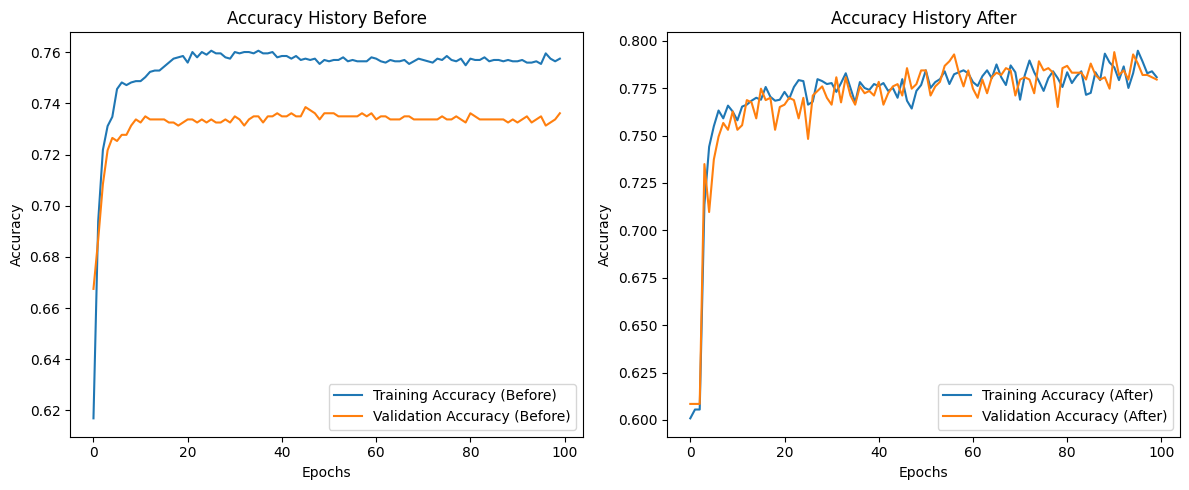

In [346]:
plot_accuracy_history_comparision(history_before=history_FFNW_before, history_after=history_FFNW_after)

#### Recurrent Neural Network

- Với mô hình FFNN, em đã thay đổi áp dụng các phương thức Regularization L1L2, tăng thêm các lớp và số lượng Neural, dropout để giảm thiểu tình trạng Overfit cũng như tối ưu hiệu suất mô hình.
- Sau khi ứng dụng có thể thấy sự thay đổi đáng kể trong Accuracy

Epoch 1/100
61/61 [==============================] - 8s 29ms/step - loss: 0.8347 - accuracy: 0.6055 - val_loss: 0.7981 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 1s 17ms/step - loss: 0.7725 - accuracy: 0.6055 - val_loss: 0.7442 - val_accuracy: 0.6084
Epoch 3/100
61/61 [==============================] - 1s 17ms/step - loss: 0.7257 - accuracy: 0.6055 - val_loss: 0.6963 - val_accuracy: 0.6084
Epoch 4/100
61/61 [==============================] - 1s 17ms/step - loss: 0.6599 - accuracy: 0.6525 - val_loss: 0.5932 - val_accuracy: 0.7096
Epoch 5/100
61/61 [==============================] - 1s 17ms/step - loss: 0.6095 - accuracy: 0.6908 - val_loss: 0.5697 - val_accuracy: 0.7193
Epoch 6/100
61/61 [==============================] - 1s 16ms/step - loss: 0.5918 - accuracy: 0.7006 - val_loss: 0.5642 - val_accuracy: 0.7482
Epoch 7/100
61/61 [==============================] - 1s 16ms/step - loss: 0.5817 - accuracy: 0.7187 - val_loss: 0.5448 - val_accuracy: 0.7566
Epoch 

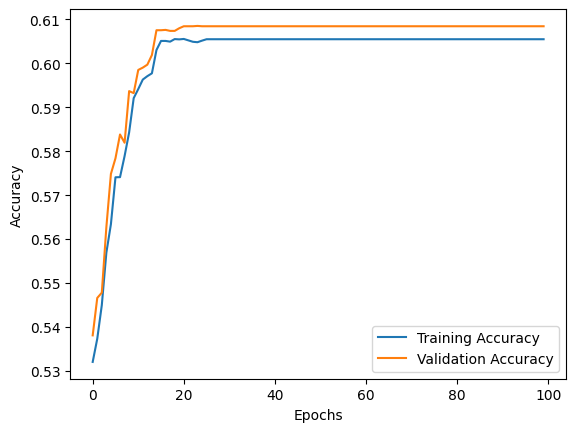

In [351]:

model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 64, activation='relu', return_sequences=True, input_shape= (X_train.shape[1],1), dropout=0.15, kernel_regularizer=regularizers.L1L2(0.02)),
    tf.keras.layers.LSTM(units = 32, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 16, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 16, activation='relu', return_sequences=True,  dropout=0.15),
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid'),
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN_after = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plot_accuracy_history(history_RNN)


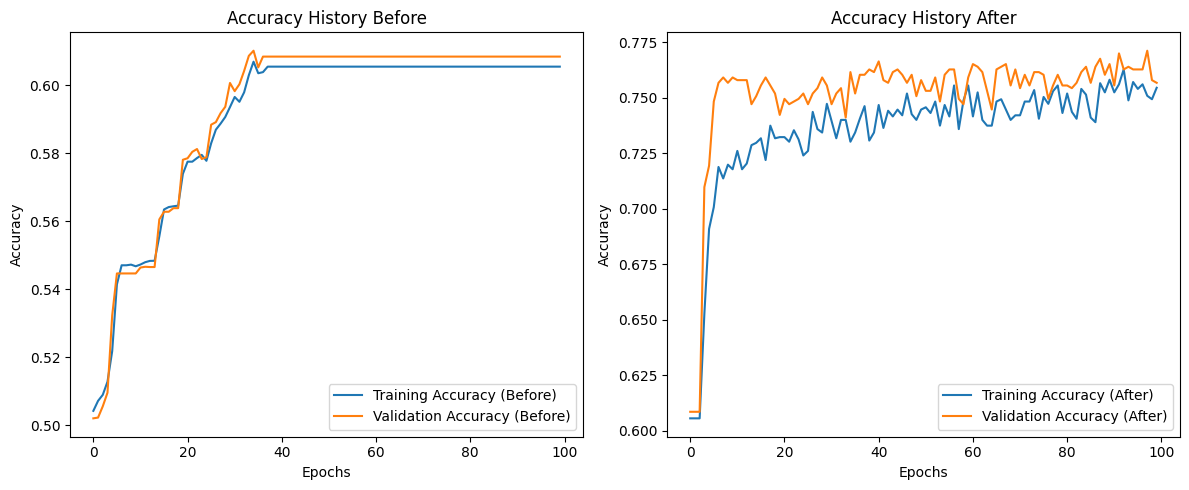

In [353]:
plot_accuracy_history_comparision(history_before=history_RNN_before, history_after=history_RNN_after)

## Phần 5: Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không. 

### Các mô hình cơ bản:

### Các mô hình Essembled

### Các mô hình Neural Network:

- Đầu tiên ta cần phải hiển trong NN có 2 khái niệm khá quan trọng đó chính là Variance và Bias.
    - Variance chính là sai số accuracy giữa tập train và tập test: Variance = accuracy_train - accuracy_test
    - Bias mô tả khả năng học của mô hình, được tính: Bias = 1 - accuracy_test
    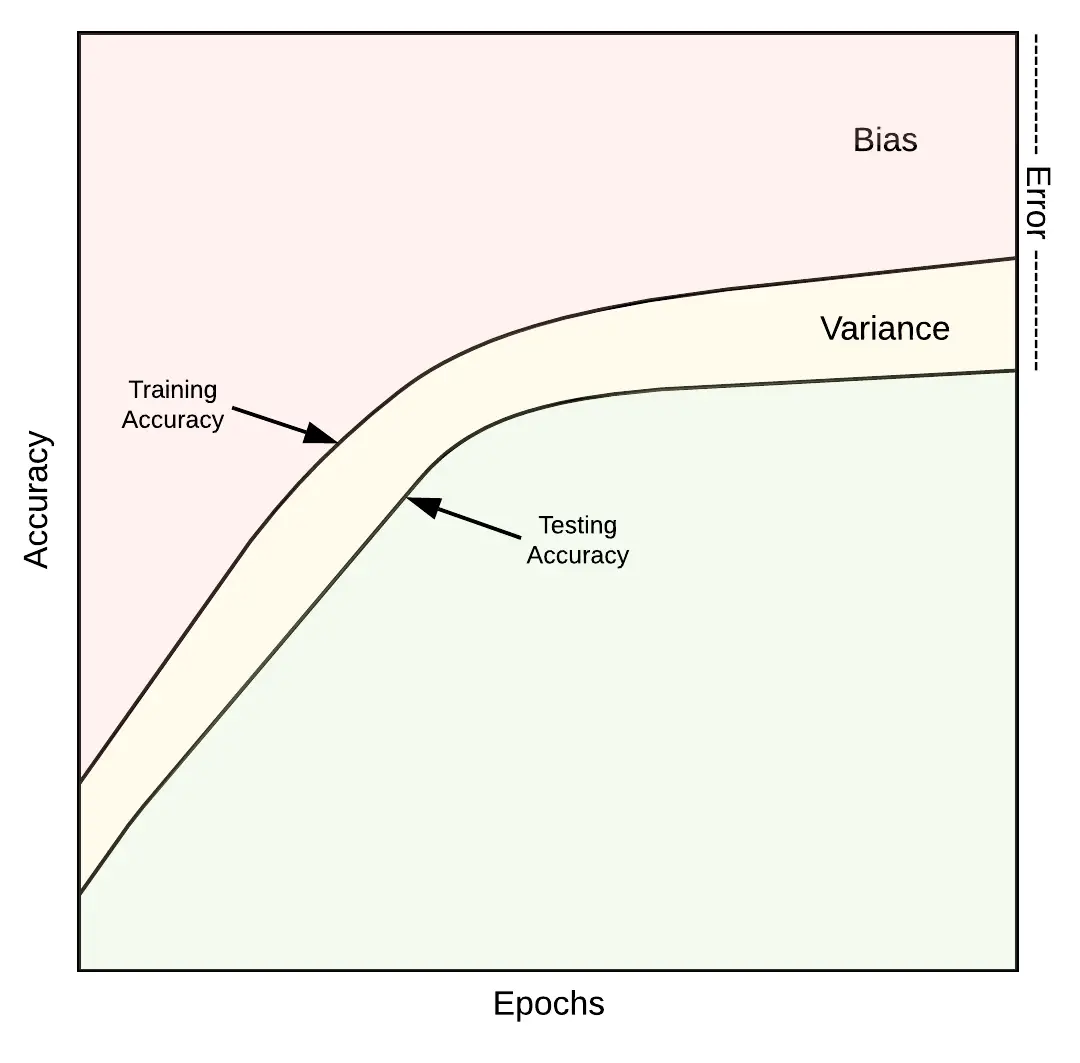

#### Với mô hình FFNN:

- Tại mô hình FFNN, dựa vào kết quả ban đầu thu được:

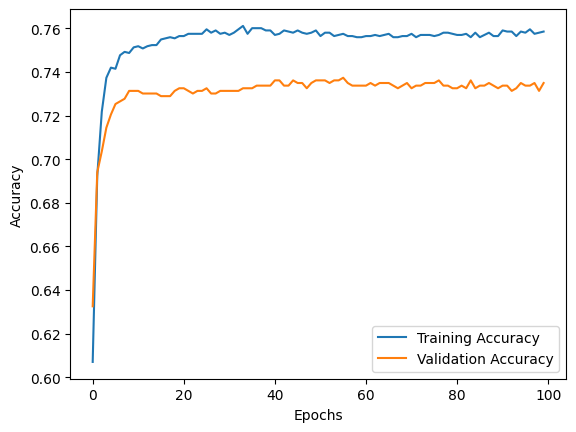

- Em đã xác định mình cần điều chỉnh bằng cách Giảm cả Bias và Variance để có thể tối ưu khả năng học của mô hình và tăng độ chính xác, do đó em đã thực hiện các bước sau: 
    - Increase model size => Giảm Bias (Tăng số lớp lẫn số node trong mỗi lớp).
    - Thêm Regularization => Giảm Variance (0.25)
    - Giảm Regularization => Giảm Bias (Giảm xuống còn 0.05)
    - Thay đổi các cấu trúc => Giảm Bias (Lựa chọn Optimizer, lựa chọn hàm activation Relu)
    - Sử dụng Feature Selection => Giảm Variance (Sử dụng Pearson Correlation để loại bỏ các Feature có Correlation trên 0.5)
- Và đây là kết quả sau thi thu lại được:

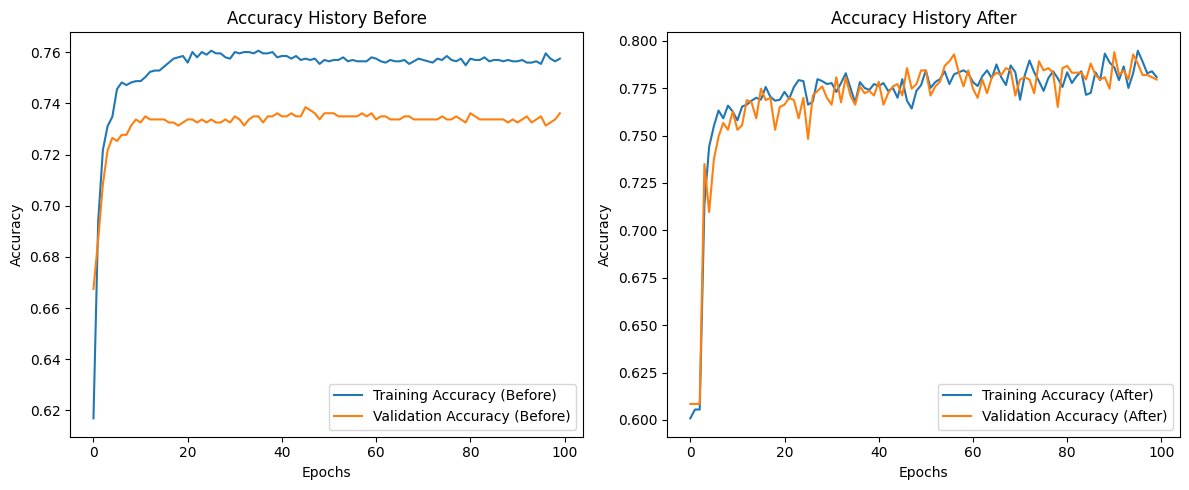

- Có thể thấy Accuracy đã tăng lên đáng kể và sự sai lệch giữa Accuracy giữa tập train và tập test đã đồng bộ với nhau.

#### Với mô hình RNN:

- Kết quả thu được ban đầu của mô hình RNN:

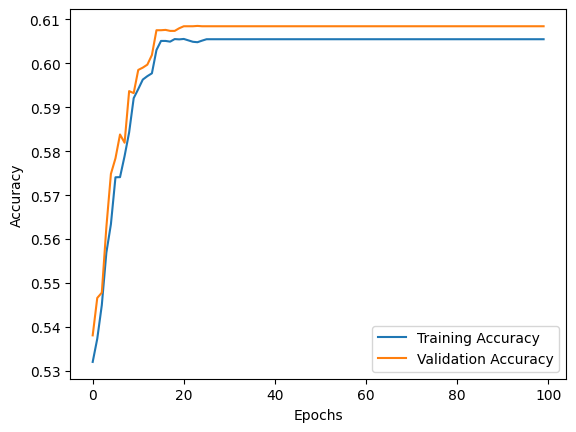  

- Dựa vào kết quả thu được ta có thể thấy cần phải giảm Bias, đây là cách thức em đã sử dụng:
    - Tăng kích thước của mô hình => Giảm Bias (Thêm nhiều lớp và điều chỉnh số Neural ở mỗi lớp)
    - Thay đổi cấu trức => Giảm Bias (Lựa chọn các hàm kích hoạt và Optimizer)
    - Thêm và điều chỉnh Regularization L1L2 => Cùng giảm Bias và Variance (lựa chọn 0.02)
- Sau cùng đây là kêt quả thu lại được, có thể thấy sự thay đổi đáng kể trong Accuracy

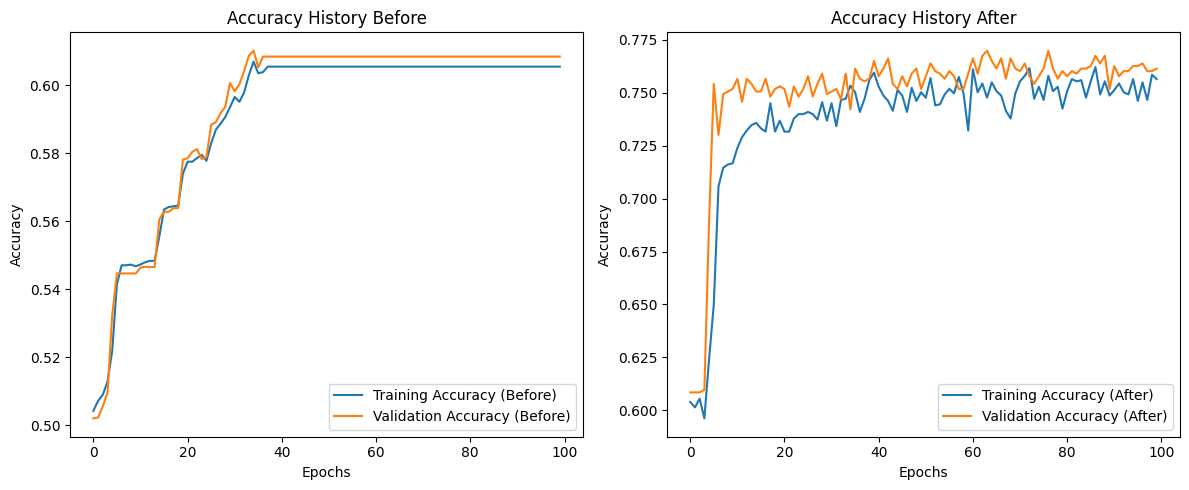
